In [158]:
import einops
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import torch.nn.functional as F

In [59]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
    """Convert an array to an image.

    Arguments:
        arr : array-like The image data. The shape can be one of MxN (luminance),
            MxNx3 (RGB) or MxNx4 (RGBA).
        vmin : scalar, optional lower value.
        vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
            image by fixing the values that map to the colormap color limits. If
            either *vmin* or *vmax* is None, that limit is determined from the *arr*
            min/max value.
        cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
            registered colormap name. The colormap maps scalar data to colors. It is
            ignored for RGB(A) data.
                Defaults to :rc:`image.cmap` ('viridis').
        origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
            of the array is in the upper
                left or lower left corner of the axes.    Defaults to :rc:`image.origin`
                    ('upper').

    Returns:
        A uint8 image array.
    """
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin, vmax)
    if origin is None:
        origin = mpl.rcParams["image.origin"]
    if origin == "lower":
        arr = arr[::-1]
    rgba = sm.to_rgba(arr, bytes=True)
    return rgba

def rawarrview(array, **kwargs):
    """Visualize an array as if it was an image in colab notebooks.

    Arguments:
        array: an array which will be turned into an image.
        **kwargs: Additional keyword arguments passed to imify.
    """
    f = io.BytesIO()
    imarray = imify(array, **kwargs)
    plt.imsave(f, imarray, format="png")
    f.seek(0)
    dat = f.read()
    f.close()
    display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
    """Given an array of shape [n, x, y, ...] reshape it to create an image field.

    Arguments:
        array: The array to reshape.
        cut: Optional cut on the number of images to view. Will default to whole
            array.
        rows: Number of rows to use.    Will default to the integer less than the
            sqrt.
        axis: Axis to interpretate at the batch dimension.    By default the image
            dimensions immediately follow.

    Returns:
        reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
    """
    original_shape = array.shape
    assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

    if cut is None:
        cut = original_shape[axis]
    if rows is None:
        rows = int(math.sqrt(cut))

    cols = cut // rows
    cut = cols * rows

    leading = original_shape[:axis]
    x_width = original_shape[axis + 1]
    y_width = original_shape[axis + 2]
    remaining = original_shape[axis + 3:]

    array = array[:cut]
    array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
    array = torch.moveaxis(array, axis + 2, axis + 1)
    array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
    return array

def zoom(im, k, axes=(0, 1)):
    for ax in axes:
        im = np.repeat(im, k, ax)
    return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
    if normalize:
        im = im - im.min()
        im = im / im.max()
    return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

In [10]:
## Hyperparameters

In [102]:
training_data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        lambda img: torchvision.transforms.functional.rotate(img, -90),
        lambda img: torchvision.transforms.functional.hflip(img),
        torchvision.transforms.ToTensor()
    ])
)

test_data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        lambda img: torchvision.transforms.functional.rotate(img, -90),
        lambda img: torchvision.transforms.functional.hflip(img),
        torchvision.transforms.ToTensor()
    ])
)

In [103]:
BATCH_SIZE = 512
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [104]:
inputs, classes = next(iter(train_dataloader)) 

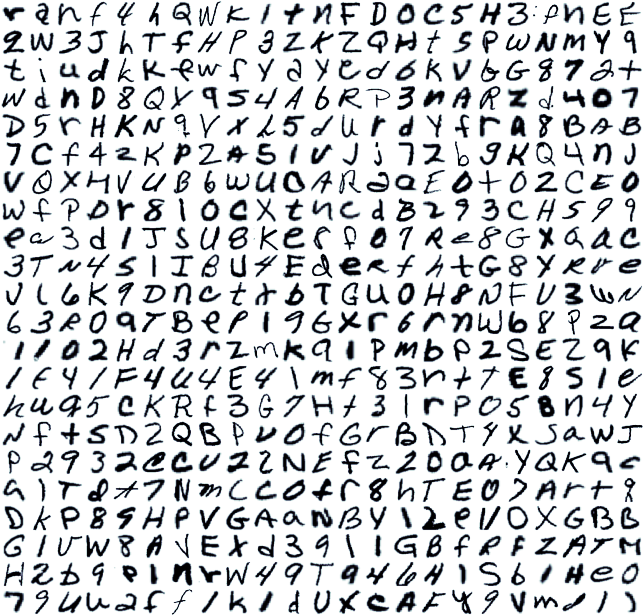

In [105]:
rawarrview(reshape_image_batch(inputs.reshape(-1, 28, 28)), cmap='bone_r')

In [121]:
def gamma(ts, gamma_min=-6, gamma_max=6):
    return gamma_max + (gamma_min - gamma_max) * ts

def sigma2(gamma):
    return torch.sigmoid(-gamma)

def alpha(gamma):
    return torch.sqrt(1 - sigma2(gamma))

def variance_preserving_map(x, gamma, eps):
    a = alpha(gamma)
    var = sigma2(gamma)
    return a * x + torch.sqrt(var) * eps

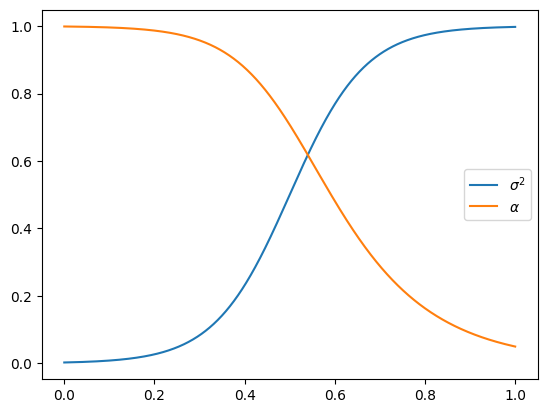

In [119]:
ts = torch.from_numpy(np.linspace(0, 1, 1000))
plt.plot(ts, sigma2(gamma(ts)), label=r'$\sigma^2$')
plt.plot(ts, alpha(gamma(ts)), label=r'$\alpha$')
plt.legend();

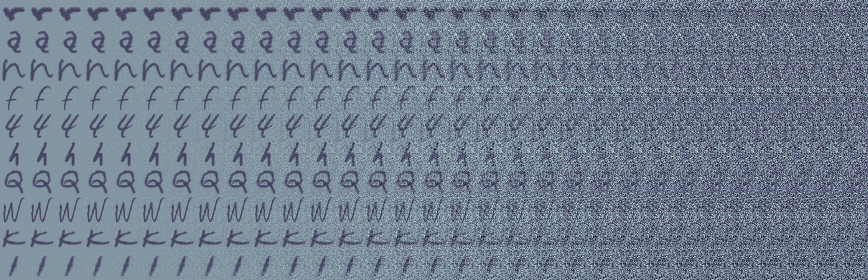

In [286]:
changed_inputs = 2 * inputs[:10].reshape(-1, 28, 28) - 1
T = 30
results = torch.zeros((10, T + 1, 28, 28))
results[:,0] = changed_inputs

tt = torch.from_numpy(np.linspace(0, 1, T))
eps = torch.normal(0, 1, (10, 28, 28))
for i, t in enumerate(tt):
    results[:,i+1] = variance_preserving_map(changed_inputs, gamma(t), eps)
rawarrview(reshape_image_batch(results.reshape((-1, 28, 28)), rows=10), cmap='bone_r')

In [170]:
INPUT_DIM = einops.rearrange(inputs[0], '... x y d -> ... (x y d)').shape[0]

In [181]:
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=torch.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.type(dtype)[:, None] * emb[None, :]
    emb = torch.concatenate([torch.sin(emb), torch.cos(emb)], axis=1)
    if embedding_dim %2 == 1: # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [227]:
class ResNetBlock(nn.Module):
    def __init__(self, input_size=512, middle_size=1024):
        super().__init__()
        self.input_ff = nn.Sequential(
            nn.LayerNorm(input_size), 
            nn.GELU(), 
            nn.Linear(input_size, middle_size)
        )
        self.ff_cond = nn.Linear(input_size, middle_size, bias=False)
        self.ln_output = nn.Sequential(
            nn.LayerNorm(middle_size), nn.GELU()
        )
        self.ff_output = nn.Linear(middle_size, input_size)
        torch.nn.init.zeros_(self.ff_output.weight)

    def forward(self, z, cond=None):
        h = self.input_ff(z)
        if cond is not None:
            h += self.ff_cond(cond=cond)
        h = self.ln_output(h)
        h = self.ff_output(h)
        return z + h
        
        
class ResNet(nn.Module):
    def __init__(self, n_layers, input_size):
        super().__init__()
        self.blocks = [ResNetBlock(input_size=input_size) for _ in range(n_layers)]
        
            
    def forward(self, x, cond=None):
        h = x
        for block in self.blocks:
            h = block(x, cond=cond)
        return h

In [267]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=256, n_layers=3, z_dim=8):
        super().__init__()
        
        self.input_ff = nn.Linear(INPUT_DIM, hidden_size)
        self.res_net = ResNet(n_layers, hidden_size)
        self.param_ff = nn.Linear(hidden_size, z_dim)
    
    def forward(self, ims, cond=None):
        x = 2.0 * ims.type(torch.float32) - 1.0
        x = einops.rearrange(x, '... x y d -> ... (x y d)')
        x = self.input_ff(x)
        x = self.res_net(x, cond=cond)
        params = self.param_ff(x)
        return params

class Decoder(nn.Module):
    def __init__(self, hidden_size=512, n_layers=3, z_dim=8):
        super().__init__()
        
        self.input_ff = nn.Linear(z_dim, hidden_size)
        self.res_net = ResNet(n_layers, hidden_size)
        self.logits = nn.Linear(hidden_size, INPUT_DIM)
        self.sigm = nn.Sigmoid()
        
    
    def forward(self, z, cond=None):
        z = self.input_ff(z)
        z = self.res_net(z, cond=cond)
        logits = self.sigm(self.logits(z))
        logits = einops.rearrange(logits, '... (x y d) -> ... x y d', x=28, y=28, d=1)
        return torch.bernoulli(logits)

class ScoreNet(nn.Module):
    def __init__(self, embedding_dim=128, z_dim=8, n_layers=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.cond_ff = nn.Sequential(
            nn.Linear(INPUT_DIM, embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(embedding_dim * 4, embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(embedding_dim * 4, embedding_dim)
        )
        
        self.latent_ff = nn.Linear(z_dim, embedding_dim)
        self.res_net = ResNet(n_layers, embedding_dim)
    
    def forward(self, z, g_t, conditioning):
        t = g_t * torch.ones(z.shape[0])
        
        t_emb = get_timestep_embedding(t, self.embedding_dim)
        cond = torch.concatenate([t_emb, conditioning], axis=1)
        cond = self.ff(cond)
        
        h = self.latent_ff(z)
        h = self.res_net(h, cond)
        return z + h
        

In [268]:
enc = Encoder()
dec = Decoder()
score = ScoreNet()
block = ResNetBlock()
res_net = ResNet(3, INPUT_DIM)

In [257]:
res = dec(enc(inputs))